In [1]:
import sys
sys.path.append('../..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import FilterGeneticAlgorithm
import random as rnd
from tools.GA.CropGeneticAlgorithm import CropGeneticAlgorithm

In [2]:
path = "../datasets/Images/Skin canser"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

../datasets/Images/Skin canser/benign
../datasets/Images/Skin canser/malignant


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            img=cv.resize(img, (224,224))
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])

In [8]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [31]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 15ms/step - loss: 0.9770 - accuracy: 0.7879
0.6323232382535935


In [10]:
filterGeneticAlgorithm=FilterGeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [11]:
best_filter= filterGeneticAlgorithm.run(generation_limit=10, population_size=24)

--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 1.5328 - accuracy: 0.5739
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.6319424033164978
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 18ms/step - loss: 0.7113 - accuracy: 0.5957
filter [18, 110, 58, 243, 12, 211, 130, 20, 146, 121, 27, 1, 5, 27, 348, 2] fit: 0.60642009973526
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 18ms/step - loss: 0.6110 - accuracy: 0.6565
filter [45, 130, 27, 169, 15, 178, 117, 47, 122, 178, 19, 5, 3, 168, 54, 0] fit: 0.7290607929229737
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.9545 - accuracy: 0.5565
filter [31, 151, 17, 243, 52, 179, 111, 49, 

In [12]:
print(f"\nbest filter :{best_filter.filter} fit: {best_filter.fit}")


best filter :[53, 116, 18, 251, 67, 130, 79, 96, 7, 54, 12, 4, 5, 68, 422, 0] fit: 0.7871823787689209


In [13]:
filtered_X_train=np.array(filterGeneticAlgorithm.get_newData(X_train,filter=best_filter.filter))
filtered_X_test=np.array(filterGeneticAlgorithm.get_newData(X_test,filter=best_filter.filter))


print(f"X_train:{filtered_X_train.shape} Y_train:{Y_train.shape} X_test:{filtered_X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


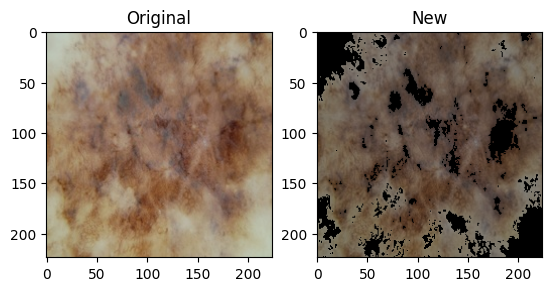

In [14]:
index=rnd.randint(0,len(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(filtered_X_test[index])
ax2.set_title('New')

plt.show()

In [29]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(filtered_X_test)[train_index], np.array(filtered_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 15ms/step - loss: 1.1007 - accuracy: 0.7677
0.7404040455818176


In [18]:
cropGeneticAlgorithm=CropGeneticAlgorithm(X_train=filtered_X_train,X_test=filtered_X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [19]:
best_crop=cropGeneticAlgorithm.run(generation_limit= 10, population_size= 10)

--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.6987 - accuracy: 0.7565
crop [(0, 224), (0, 224)] fit: 0.7750178813934326
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.7533 - accuracy: 0.7304
crop [(72, 218), (192, 203)] fit: 0.7230246543884278
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.7662 - accuracy: 0.6913
crop [(5, 28), (25, 221)] fit: 0.7026331722736359
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17ms/step - loss: 0.5840 - accuracy: 0.7391
crop [(73, 116), (124, 174)] fit: 0.7325522243976593
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 17m

In [24]:
best_crop.crop_dimension

[(0, 224), (0, 224)]

In [20]:
cropped_X_train=np.array(cropGeneticAlgorithm.get_newData(filtered_X_train,best_crop.crop_dimension))
cropped_X_test=np.array(cropGeneticAlgorithm.get_newData(filtered_X_test,best_crop.crop_dimension))

print(f"X_train:{cropped_X_train.shape} Y_train:{Y_train.shape} X_test:{cropped_X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


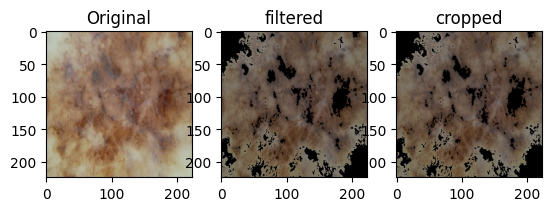

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(filtered_X_test[index])
ax2.set_title('filtered')

ax3.imshow(cropped_X_test[index])
ax3.set_title('cropped')

plt.show()

In [23]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(cropped_X_test)[train_index], np.array(cropped_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 15ms/step - loss: 1.0778 - accuracy: 0.7071
0.7464646458625793


In [25]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(cropped_X_test)[train_index], np.array(cropped_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=2, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

Epoch 1/2
28/28 [==============================] - 2s 65ms/step - loss: 1.2833 - accuracy: 0.6723
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: 0.4796 - accuracy: 0.8889
Epoch 1/2
28/28 [==============================] - 2s 66ms/step - loss: 1.9646 - accuracy: 0.6790
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: 0.5794 - accuracy: 0.7879
Epoch 1/2
28/28 [==============================] - 2s 66ms/step - loss: 1.1613 - accuracy: 0.6857
Epoch 2/2
4/4 [==============================] - 0s 16ms/step - loss: 1.0891 - accuracy: 0.7576
Epoch 1/2
28/28 [==============================] - 2s 66ms/step - loss: 1.5669 - accuracy: 0.7194
Epoch 2/2
4/4 [==============================] - 0s 16ms/step - loss: 0.6335 - accuracy: 0.7172
Epoch 1/2
28/28 [==============================] - 2s 66ms/step - loss: 0.7605 - accuracy: 0.7160
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: 0.7188 - accuracy: 0.7778
Epoch 1/2
28/28 [=============